# A Tutorial on Neural Networks

In this tutorial, we're going to translate some of the concepts that we've been talking about in the lecture part into code. 

**Advanced Exercise** (to do at home): it is really, really instructive to write your own code implement and train a neural network, including the backpropagation and gradient descent. I highly encourage you to do so, for your own understanding of the subject matter. However, this would take more time than we have today, so today we'll use an existing library.

### Neural Network Libraries

There are basically two major libraries for neural networks: [tensorflow](https://www.tensorflow.org) (designed and supported by Google) and [torch](http://torch.ch) (originally used by the Facebook AI Research group). These libraries realistically underpin the vast majority of neural network-based machine learning applications today. A third open-source library, theano, existed, but has been moved to the [aesara](https://github.com/aesara-devs/aesara) project and is primarily maintained to support a probabilistic modeling package called [pymc3](https://docs.pymc.io/en/v3/) (check it out! it's very cool!). 

Which package you use depends, to some extent, on personal preference. While I mentioned above that you should absolutely try two write your own basic implementation of a  neural network, I probably wouldn't suggest to use it for actual research (or other) applications. Both tensorflow and torch are well-supported packages that are heavily optimized to make training neural networks fast and efficient. 

Both tensorflow and torch contain lower-level functionality that underpins a lot of the clever optimization. One of them is high-performance numerical computing (e.g. with the [JAX](https://jax.readthedocs.io/en/latest/#) library). Similarly, there are higher-level layers built on top of tensorflow and torch that make model-building in practice a lot easier and more efficient. Of particular interest to you might be [keras](https://keras.io), which is built on top of tensorflow, and [pytorch](https://pytorch.org), which provides a python interface layer to torch. 

Traditionally, Bayesian inference is really hard because the posterior is usually analytically intractable, and methods to approximate it are often slow and computationally expensive. There has been a recent push to make some of the infrastructure and insights of building efficient machine learning algorithms for probabilistic inference, and there are now some relatively new packages that implement some of these new ideas. PyMC3, as mentioned above, has been doing this for a long time, but is now joined by [edward2](https://github.com/google/edward2) (built on tensorflow) and [pyro](http://pyro.ai) (built on torch). 

### Imports

Today, we'll use PyTorch to build neural networks and train them. So let's start with some imports:

In [1]:
# some plotting stuff
#%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

## PyTorch Imports ##

# general PyTorch library
import torch
# neural network subpackage
from torch import nn
# data loading functionality
from torch.utils.data import DataLoader

# import example dataset
from torchvision import datasets

# we basically always need numpy :)
import numpy as np

We'll also load some pre-designed operations that transform data sets into something that might be easier to understand for machine learning algorithms:

In [3]:
from torchvision.transforms import ToTensor, Lambda, Compose

## GPU Support

Machine learning libraries (and machine learning algorithms) really shine if you can run them on GPUs, particulary the powerful GPUs designed for deep learning. This requires installation of PyTorch with GPU support, specifically with the CUDA toolkit and NVIDIA's GPUs. We unfortunately don't have them available for this school, but keep in mind that if you can, running on the GPU may speed up your code considerably.

You can check whether your PyTorch was installed with CUDA support via this command:

In [6]:
torch.cuda.is_available()

False

## PyTorch Nitty-Gritty Tensor Basics

Before we get to learning, we'll have to briefly talk about some of the PyTorch-specific objects first. In particular, a lot of PyTorch is based on it's own `Tensor` object. Think of `Tensor` objects as similar to `numpy.ndarray`s, but optimized to be optimized for efficient Linear Algebra operations on GPUs. 

Let's show some elementary operations, and compare them to its numpy equivalents. To give credit: A lot of this material comes from some of the basic [PyTorch tutorials](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html), which are a great resource for learning how to use the library. I'd highly recommend checking them out!

Let's make a 2-dimensional array (basically a matrix) and turn it into both a numpy array and a `Tensor`:

In [9]:
x = [[1, 2, 3], [4, 5, 6], [7,8,9]]

In [11]:
x_np = np.array(x)
print(f"x: {x_np}" )
print(f"type of x: {type(x_np)}")

x: [[1 2 3]
 [4 5 6]
 [7 8 9]]
type of x: <class 'numpy.ndarray'>


In [12]:
x_to = torch.tensor(x)
print(f"x: {x_to}")
print(f"type of x: {type(x_to)}")

x: tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])
type of x: <class 'torch.Tensor'>


PyTorch supports many basic operations, including arithmetic, matrix manipulation, linear algebra and others, similar to numpy, except you can run it on the GPU. 

Be aware that by default, `torch.Tensor` objects are created on the *CPU*, even if you've checked that GPU support is available. You still need to move it to the GPU explicitly to perform operations. Here's how you'd do that (note that for us, the command won't do anything):

In [ ]:
if torch.cuda.is_available():
    x_to = x_to.to("cuda")

You can check the device of your tensor like this:

In [15]:
x_to.device

device(type='cpu')

Here are some things we can do with tensors.

1) Arithmetic operations:

In [13]:
y_to = torch.tensor([[11, 12, 13], [14, 15, 16], [17,18,19]])

In [14]:
x_to + y_to

tensor([[12, 14, 16],
        [18, 20, 22],
        [24, 26, 28]])

Matrix multiplication can be performed in a number of different ways:

In [17]:
z = x_to @ y_to.T
print(z)

tensor([[ 74,  92, 110],
        [182, 227, 272],
        [290, 362, 434]])


In [20]:
z = x_to.matmul(y_to.T)
print(z)

tensor([[ 74,  92, 110],
        [182, 227, 272],
        [290, 362, 434]])


Note that the `*` is used for *element-wise* multiplication:

In [21]:
z = x_to * y_to
print(z)

tensor([[ 11,  24,  39],
        [ 56,  75,  96],
        [119, 144, 171]])


You can achieve the same result using the `mul` operator:

In [22]:
z = x_to.mul(y_to)

Like `numpy`, `pytorch` has some functionality to draw random numbers, or to generate tensors of a certain size populated with ones or zeros:

In [24]:
# draw random numbers
r = torch.rand((4, 4))
print(r)

tensor([[0.7570, 0.4105, 0.0315, 0.3648],
        [0.9724, 0.2274, 0.5618, 0.6928],
        [0.4814, 0.9762, 0.6851, 0.0273],
        [0.1748, 0.1514, 0.6521, 0.0316]])


In [26]:
# populate an array of size (2,3) with zeros
z = torch.zeros((2,3))
print(z)
print(z.shape)

tensor([[0., 0., 0.],
        [0., 0., 0.]])
torch.Size([2, 3])


In [27]:
# populate an array of size (2,6) with ones
o = torch.ones((2,6))
print(o)
print(o.shape)

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])
torch.Size([2, 6])


In [28]:
# populate an array of size (3,2) with random normal numbers
r = torch.randn((3,2))
print(r)
print(r.shape)

tensor([[ 1.1881, -0.7630],
        [-0.7025,  0.1884],
        [ 0.0544,  1.9183]])
torch.Size([3, 2])


You can transfer a torch Tensor to a numpy array like this:

In [29]:
on = o.numpy()
print(on)
print(f"type of on: {type(on)}")

[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
type of on: <class 'numpy.ndarray'>


## Learning Hand-Written Digits

In the lecture, we explored how we might theoretically train a computer to recognize handwritten digits. Let's now explore this in code. The [MNIST Handwritten Digits Database](http://yann.lecun.com/exdb/mnist/) is a great resource to get started: it's a very well-studied, extremely well-curated dataset. It doesn't have a lot of weird data issues and biases that you might encounter in real data sets where you're likely to apply machine learning (as we've seen yesterday, the photo-z data set has quite a few strange quirks). It's a widely used benchmark for machine learning algorithms. As of writing this tutorial, top performance stands at 99.87% (see [this website](https://paperswithcode.com/sota/image-classification-on-mnist)), using a model witih around 1.5 million parameters. Let's see how close we can get today?

Experimenting with the MNIST handwritten digits dataset has the advantage that it helps you understand how the algorithms work, and how different choices affect the classification accuracy. However, you should be aware that it also makes it pretty *easy* to implement and run a neural network and get a good result. In reality, designing, developing, testing and improving machine learning models can be a long, arduous process that requires a lot of creativity, digging into the data and experimentation. Don't get discouraged if you try this on astronomy data and it doesn't work right away!

With that in mind, let's load the MNIST data. PyTorch has a bunch of datasets pre-loaded, which makes things pretty easy.

The first time you run the command below, it will download the requisite data to whatever path you specify in `root`. PyTorch has already helpfully split the training and the test data sets, so we can load them separately by setting `train=True` for the training data set, and `train=False` for the test data set. We'll also have to set `download=True` the first time we run this, but not the next time (if you rerun this notebook).

Note that we can't use the input data as it's being provided, we need to transform both the pixel values of the images, and the labels. Firs, the `ToTensor()` transform moves the data from numpy arrays to pytorch tensors so that PyTorch can use them. Secondly, by default, the labels are stored as numbers from 0 to 9 (i.e. the number that's being displayed on the image). We're going to work with two different cases below. First, we'll look at logistic regression as a *binary* classifier. For this we're just going to answer the question "Is it a 4?". If the answer is "yes", then we'll give that label a value of 1, if it's no, the label will have a value of 0. Later on, we'll look at all of the classes with a different encoding of the labels. We can implement this by using a `Lambda` transform. `lambda` in general is a Python way to encode functions on the fly on a single like without the traditional `def function_name(parameters) ...` type syntax. PyTorch has its own version of that implemented as a transform. 



In [89]:
is_it_a_four = Lambda(lambda y: torch.tensor(1) if y ==4 else torch.tensor(0))

In [90]:
training_data = datasets.MNIST(root="data", train=True, download=False, 
                               transform=ToTensor(), target_transform=is_it_a_four)

In [91]:
test_data = datasets.MNIST(root="data", train=True, download=False, 
                           transform=ToTensor(), target_transform=is_it_a_four)

Let's visualize the data:

<IPython.core.display.Javascript object>


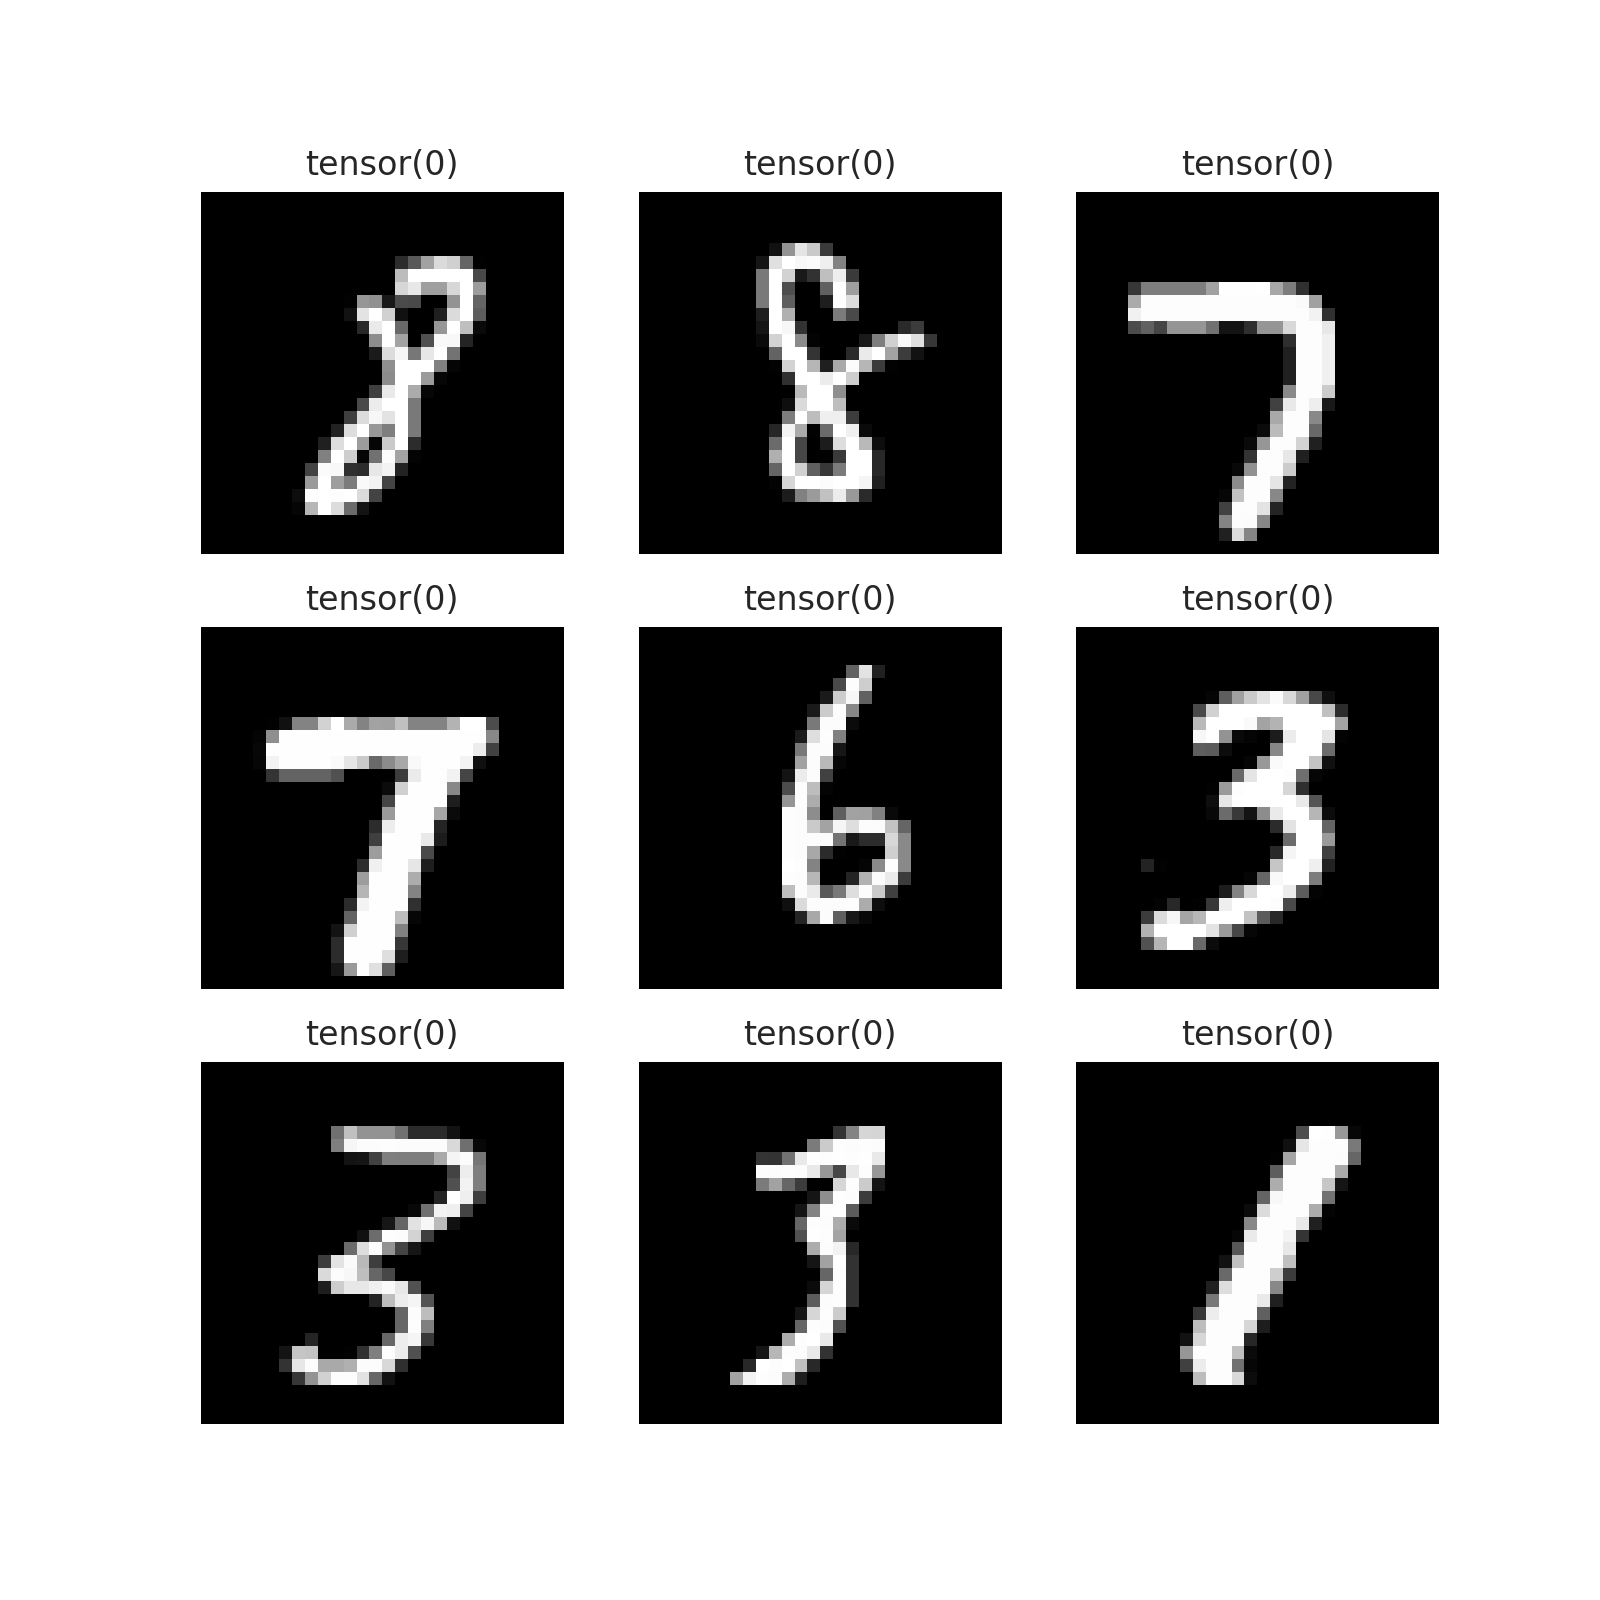

In [92]:
figure = plt.figure(figsize=(8,8))

cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


You can also create custom datasets for your data. We'll go through that process a bit later. We're now ready to build a neural network (woo!).

## Logistic Regression

Let's start simple and build the logistic regression classifier from yesterday, but this time in PyTorch. Compared to scikit-learn, this will seem very cumbersome, but that's because PyTorch is designed for way more complex things than logistic regression.

In order to build a logistic regression classifier in PyTorch, we need the `torch.nn.Linear` function. This function sets up--perhaps unsurprisingly--a linear model. It takes an `input dimension`, which is the dimension of a single image, if you unfolded it into a vector, and an `output dimension`, which here should be the dimensionality of our labels (10). Let's get out a single example from our training data to check:


In [94]:
td_sample, td_label = training_data[0]

In [95]:
input_size = td_sample.ravel().shape[0]
print(f"Input size: {input_size}")

Input size: 784


In [102]:
output_size = 1
print(f"Output size: {output_size}")

Output size: 1


So this means we have 784 input values (28 by 28 pixels) and 1 output value, as we'd expect.

In [103]:
linear = torch.nn.Linear(input_size, output_size)

We also need the sigmoid function, which is available from the `torch.nn.functional` module.

There's one more component: we need to stick these commands into a `class`. If you don't know how classes work in Python, don't panic! 

Here's the basic structure for how classes are written in PyTorch (don't execute this cell, because it won't execute):

In [ ]:
# you can freely choose the name of the class, but for PyTorch 
# neural network models, you *need* to put `torch.nn.Module` into the 
# brackets
class MyClassName(torch.nn.Module):
    
    # Whatever is in __init__ is run when you call the 
    # class and stick it into a parameter (in programming 
    # speak, you're "creating an object")
    # input parameters is stuff that helps you set up the class
    def __init__(self, input_parameters):
        
        # always call this function `super` with the name 
        #you gave the class
        super(MyClassName, self).__init__()
        
        # here's where the neural network code goes. 
        # we'll talk about that in a bit
        # In short, this is where you can define 
        # crucial pieces of your neural network
        self.stuff = torch.nn.Sequential(...)
        
    def forward(self, x):
        # here is where you put the code that generates 
        # the neural network *predictions* for the label
        # It's called forward because it's used to do
        # a forward pass through the nextwork
        y_pred = run_some_stuff(self.stuff)
        return y_pred

If this looks really confusing, don't worry! It'll hopefully become clear pretty soon.

One thing you might notice is that we've not defined anything to do backpropagation anywhere. That's because we don't need to: PyTorch will do that automatically for us. Hooray! We don't need to worry about all of these indices!

Let's take a look what this class looks like for logistic regression:

In [153]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegression, self).__init__()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()
        self.lm = torch.nn.Linear(input_size, output_size)
        
    def forward(self, x):
        xflat = self.flatten(x)
        y_pred = self.sigmoid(self.lm(xflat))
        return y_pred

Okay, so what have we done: We've made a class called `LogisticRegression` (while you *can* name your classes anything, you should probably name them something related to the problem that is easy for you to remember), and when you make an object of its type, you will have to pass it in the input dimension of your data (here, 784 pixel values) and the output dimension of the predicted labels (here, 1 value). 

You then define a variable `self.lm` (the "lm" stands for "linear model", and the `self` is important for reasons we won't go into here, but makes it possible that you can call it later in `forward`), which is a linear model with the input size and output size defined by the parameters you gave to that method. This linear model is stored for use in `forward`. 

In that function, you pass in a sample of the (training) data, so that `x` is a single image, unravelled into a vector. This method will then take this function, put it through the linear model, and then squash the entire thing through a sigmoid function. It will then return the output of that function, which should be a value between 0 and 1 and will be our predicted label. And there we go, we have a logistic regression model!

As I said, it looks complicated, but this is the basic framework you can use to start building neural networks. 

Note that you don't see the parameters anywhere. They're implicitly created by Pytorch, but we can look at it after instantiating an object of this class, so let's do that:

In [229]:
model = LogisticRegression(input_size, output_size)

You can take a look at the general structure of the model like this:

In [230]:
print(model)

LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sigmoid): Sigmoid()
  (lm): Linear(in_features=784, out_features=1, bias=True)
)


In [231]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 7.6644e-03, -1.7591e-02, -1.7960e-02,  1.1555e-02, -4.2877e-04,
         -2.0807e-02, -9.6382e-03,  3.3111e-02,  2.6022e-03, -1.0456e-04,
          1.6152e-02, -2.0531e-02, -1.5847e-02, -1.4197e-02,  2.3313e-03,
          7.3890e-03, -3.4062e-02,  3.5666e-02, -2.1947e-02,  9.8998e-03,
         -9.4367e-04,  2.5487e-02,  1.8788e-03, -2.8835e-02, -4.4607e-03,
         -1.4232e-02,  2.6581e-02, -2.3180e-02,  2.3603e-02,  4.0306e-03,
          3.2756e-02,  3.5304e-02, -3.3905e-02,  2.5903e-02,  2.0799e-02,
         -1.8344e-02,  1.4733e-02,  5.4182e-03, -3.1658e-02, -3.4408e-02,
          2.0281e-02,  2.9473e-02, -9.5373e-04,  1.4919e-02, -1.9522e-02,
          2.2417e-02, -2.6330e-02, -4.4424e-03, -5.4370e-03, -2.4874e-02,
         -2.2653e-02, -3.4093e-02,  8.6181e-03,  7.4722e-03,  2.4708e-02,
          1.2873e-02,  1.1641e-02, -1.0095e-02, -1.3400e-02,  1.8438e-02,
         -6.0324e-03, -4.5765e-03, -3.4876e-02, -3.4064e-02,  2.6636e-02,
         -1.4743

There we go, those are all the weights and the bias. See how both say `requires_grad=True`? PyTorch knows, by default, that we want to calculate the gradients with respect to all of those parameters, which will come in handy later.



Let's take a look at what this predicts for a single image:

In [232]:
t_sample, t_label = training_data[145]
print(f"label: {t_label}")

y_pred = model(t_sample)

print(f"Predicted label: {y_pred}")


label: 0
Predicted label: tensor([[0.4917]], grad_fn=<SigmoidBackward>)


So really, the model is currently not sure. That's not super surprising, because it's been initialized somewhat randomly, so none of the weights have ever seen any of the data and don't know anything about our problem.

In order to make out model learn, we need a cost function.
So let's write one down. For this problem, we're going to pick the Binary Cross Entropy loss, which is designed for binary problems as we have here (remember, we're currently just figuring out whether any of the images displays a 4 or not):

In [233]:
loss = torch.nn.BCELoss(reduction="mean")

Time to do some training! 

For this, we'll need to set three parameters: 
* the learning rate 
* the batch size (remember, we're calculating gradients across mini-batches)
* the epoch (how many passes over the full data we should do.

Let's pick some options (generally, you might want to explore those):

In [252]:
learning_rate = 1e-2
batch_size = 128
epochs = 20

We could do the generation of mini-batches by hand, but we don't need to: PyTorch has a convenient structure for this called a `DataLoader`. This structure has the additional advantage that it can dynamically load mini-batches from disk. This is particularly useful when the training dataset might be too large to be loaded into memory all at once. 

Because the training data is pretty big, we're going to pick a subset and just look at those examples to speed up training.

In [253]:
idx_train = torch.randperm(len(training_data))[:15000]
idx_test = torch.randperm(len(test_data))[:5000]

training_data_small = torch.utils.data.Subset(training_data, idx_train)
test_data_small = torch.utils.data.Subset(test_data, idx_test)

In [254]:
train_loader = DataLoader(training_data_small, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_small, batch_size=batch_size, shuffle=True)

Now we need an optimizer to actually do the minimization of the loss function with respect to the weights. Earlier, we learned about Stochastic Gradient Descent, so let's play around with that. Later on, you'll have the chance to explore others. The optimizer takes the parameters of our `LogisticRegression` model as inputs, as well as the `learning_rate` parameter we defined above, which will give it some idea how far it should step through the space. 

In [255]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In order to do the actual training, we're going to need to loop through all of the mini-batches in our training data. Let's write a function for this to make it easier. The tra

In [256]:
def training_loop(dataloader, model, loss, optimizer):
    # total number of training examples
    n_train = len(dataloader.dataset)
    
    loss_all = []
    
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
        y = y.to(torch.float32)
        l = loss(y_pred, torch.unsqueeze(y, dim=1))
        
        # set all gradients to zero
        optimizer.zero_grad()
        
        # do backward propagation through the network
        l.backward()
        
        # let the optimizer take a step through 
        # parameter space with the gradients
        # we just computed
        optimizer.step()
        loss_all.append(l.item())
        
    if batch % 10 == 0:
        l_item = l.item()
        current = batch * len(X)
        print(f"loss : {l_item} [{current} / {n_train}]")
            

    mean_loss = np.mean(loss_all)
        
    return mean_loss

In this function, we loop over all of the mini-batches. For each mini-batch, we compute the loss between the predictions for the current minibatch of training examples and the ground-truth labels of those training examples. Then we set the gradients to zero (this is important!), and do a backward pass through the network to calculate the gradients of the loss function with respect to the parameters. Look how this takes one simple line! 
Finally, we use these gradients to let the optimizer take a step forward.

In the rest of the function we set up some printing to help us diagnose how the optimizer is doing while it's running. We're also going to record all of the losses, so we can plot them later.

Let's write an equivalent function for the test data.

**Important**: in practical applications, you'll probably want to keep the test data secret *to the very end*. That is, you don't use it to check how good your results are until you've done *all* of your neural network explorations and developments. Here, we're going to use it for exploratory purposes. 

In the test loop, we *also* run through our mini-batches, but instead of doing the backward step and optimization, we arejust going to run through the forward pass of the network for each minibatch, and record how well our classifier is doing:

In [267]:
def test_loop(dataloader, model, loss, optimizer):
    # total number of training examples
    n_test = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0 # loss of our test samples
    correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            #print(y_pred[:5])
            y = y.to(torch.float32)
            #print(y[:5])
            test_loss += loss(y_pred, torch.unsqueeze(y, dim=1)).item()
            correct += (torch.round(y_pred) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    corr_frac = correct / n_test
            
    print(f"Test loss: {test_loss}")
    print(f"Correctly classified samples: {corr_frac}")
    return test_loss


Okay, now we're finally ready to run the whole thing:

In [268]:
learning_rate = 1e-2
batch_size = 128
epochs = 20
model = LogisticRegression(input_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss_all, test_loss_all = [], []

# loop over all epochs
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    trl = training_loop(train_loader, model, loss, optimizer)
    tel = test_loop(test_loader, model, loss, optimizer)
    
    train_loss_all.append(trl)
    test_loss_all.append(tel)

Epoch 1
-----------------------
tensor([[0.2758],
        [0.0415],
        [0.1146],
        [0.0724],
        [0.1284]])
tensor([1., 0., 0., 0., 0.])
tensor([[0.0836],
        [0.1252],
        [0.0683],
        [0.0281],
        [0.0940]])
tensor([0., 0., 0., 0., 0.])
tensor([[0.0099],
        [0.0682],
        [0.1841],
        [0.0790],
        [0.0755]])
tensor([0., 0., 0., 0., 0.])
tensor([[0.0938],
        [0.1179],
        [0.1023],
        [0.0897],
        [0.0851]])
tensor([0., 0., 0., 0., 0.])
tensor([[0.0995],
        [0.2232],
        [0.1329],
        [0.1699],
        [0.1691]])
tensor([0., 0., 0., 0., 0.])
tensor([[0.2353],
        [0.0847],
        [0.0622],
        [0.0449],
        [0.0358]])
tensor([0., 0., 0., 0., 0.])
tensor([[0.0583],
        [0.0268],
        [0.0777],
        [0.0399],
        [0.0221]])
tensor([0., 0., 0., 0., 0.])
tensor([[0.0924],
        [0.0324],
        [0.2444],
        [0.1113],
        [0.1490]])
tensor([0., 0., 0., 0., 0.])
tensor([

Okay, let's take a look at the training and test losses. It's useful to plot them against the epochs:

<IPython.core.display.Javascript object>


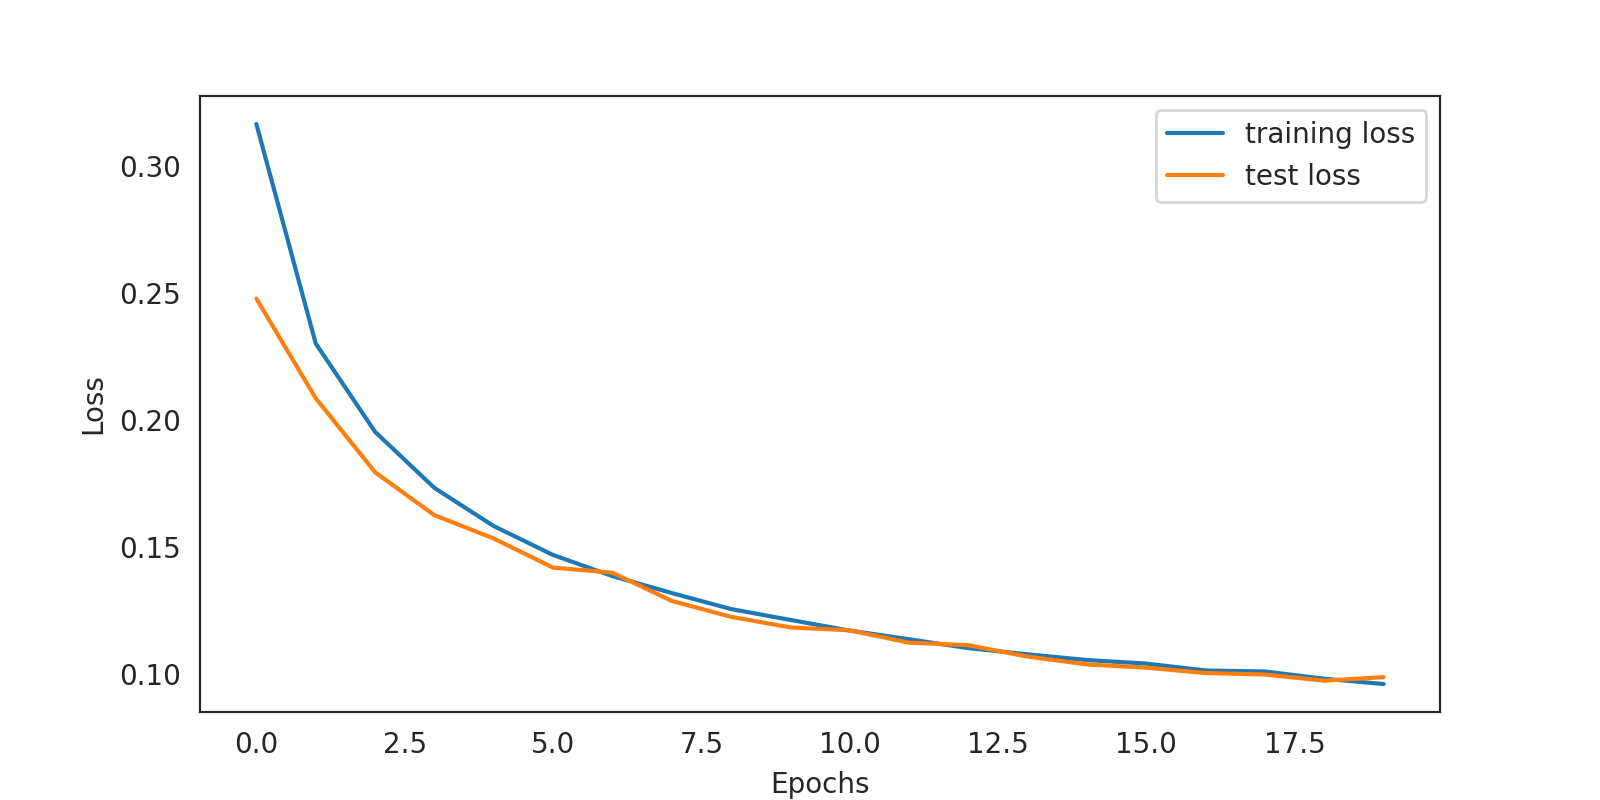

In [261]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(np.arange(epochs), train_loss_all, label="training loss")
ax.plot(np.arange(epochs), test_loss_all, label="test loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.legend()

That looks like a pretty reasonable curve, with both the training and the test loss decreasing at approximately the same rate. But what does a loss of 0.1 actuall mean?

**THIS IS NOT WORKING AND I NEED TO FIX IT!**

## Neural Networks

All right, from here, let's go and take a look at neural networks. We're going to make two immedaite changes.

If you remember back to the earlier lecture, the output layer actually consisted of *10 neurons*, one for each number, where the neuron that represented the true number displayed on the image should be 1, and everything else should be zero. Before, we looked only at whether the number on the image is a 4, now we're going to try and see whether we can classify them all together. So for this, we won't implement a `target_transform`, but rather use the labels as is.


In [308]:
training_data = datasets.MNIST(root="data", train=True, download=False, 
                               transform=ToTensor())
test_data = datasets.MNIST(root="data", train=True, download=False, 
                           transform=ToTensor())

Let's visualize these again:

<IPython.core.display.Javascript object>


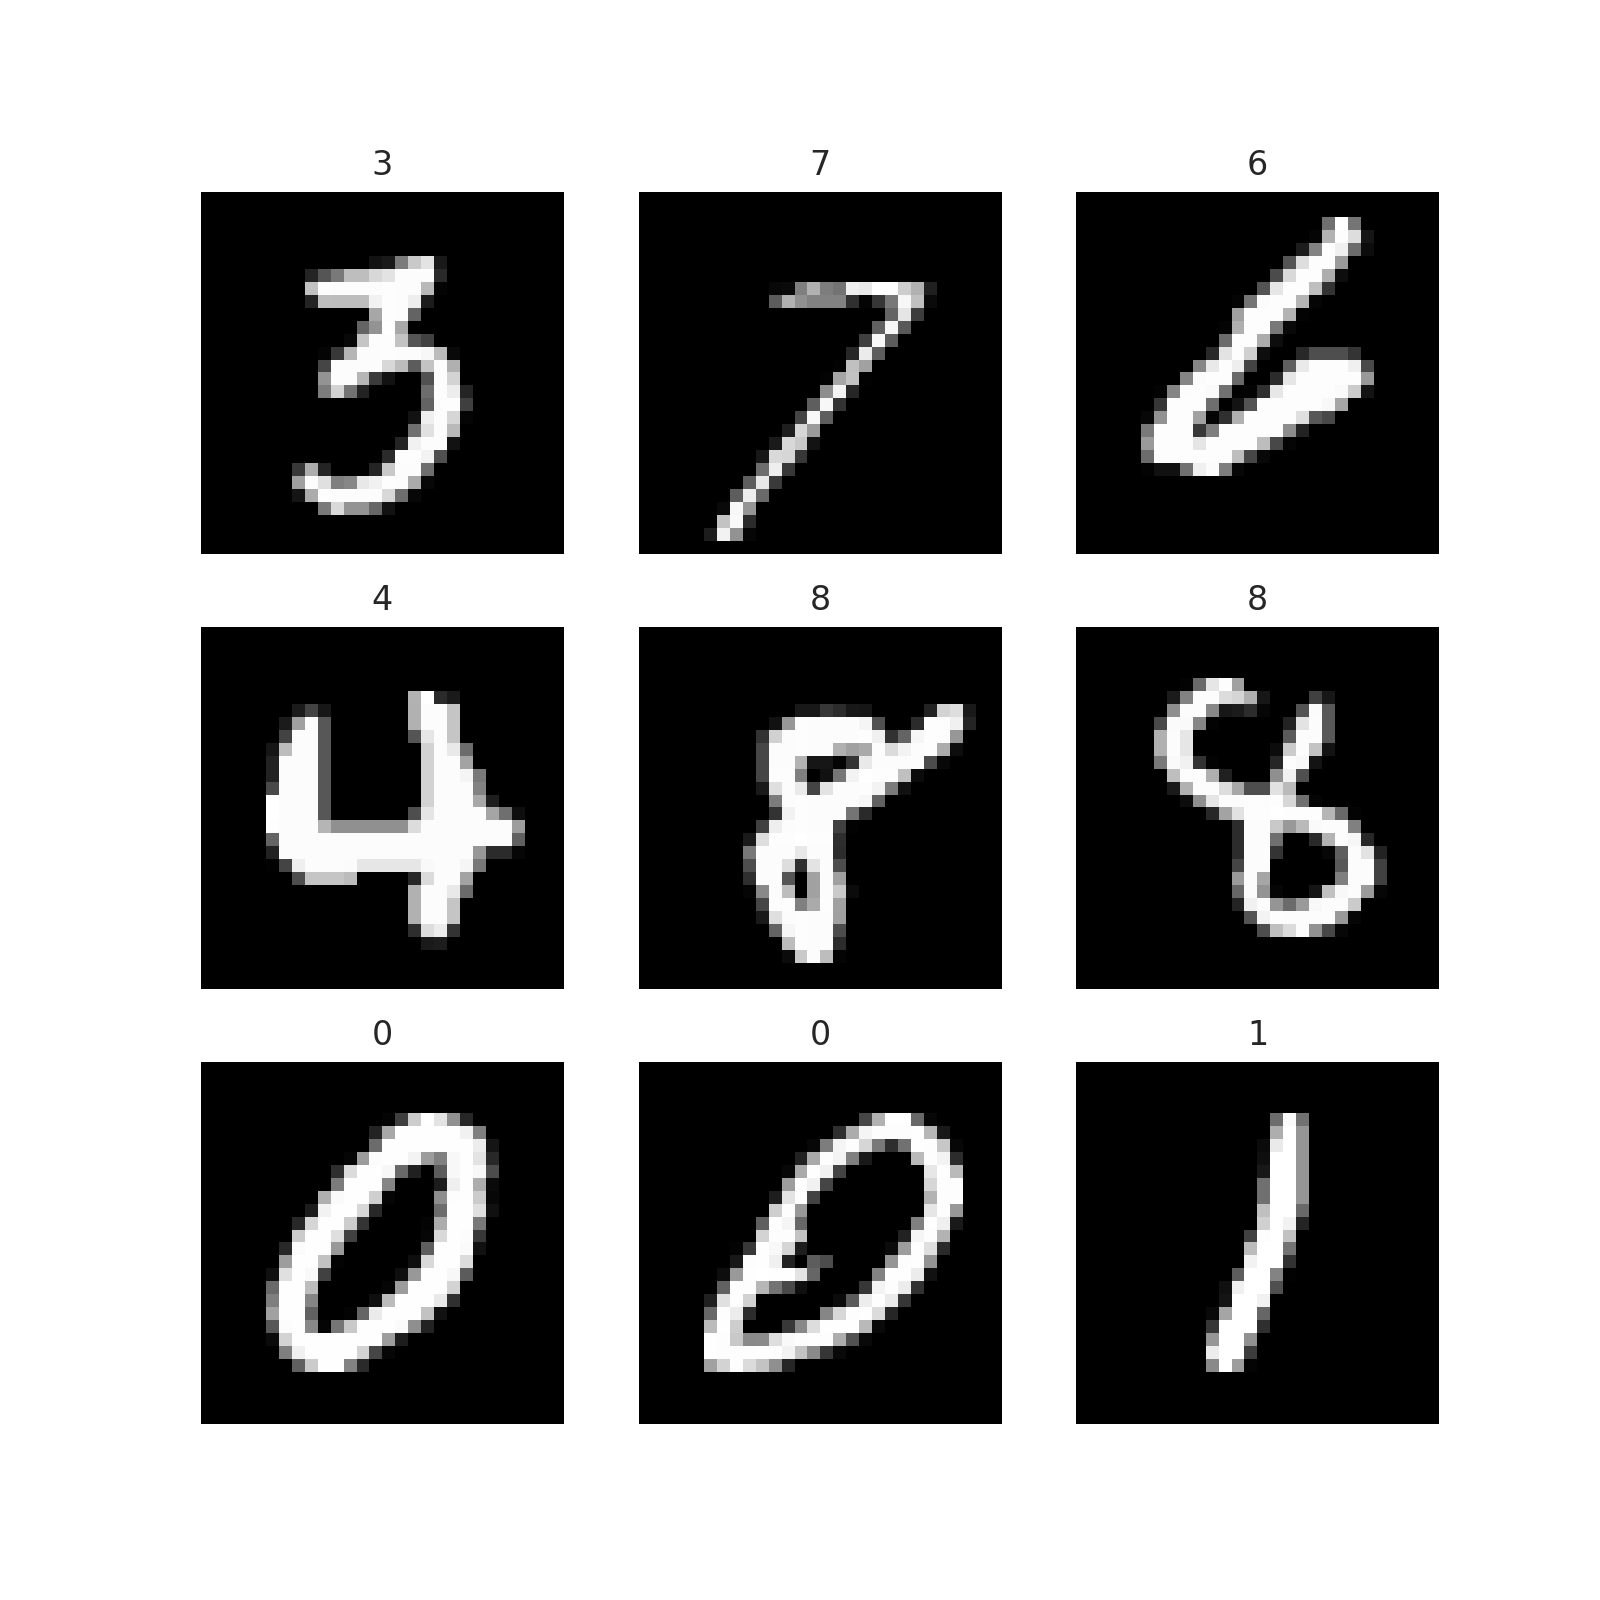

In [309]:
figure = plt.figure(figsize=(8,8))

cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()



We'll need to put these into a `DataLoader` object again:

In [320]:
idx_train = torch.randperm(len(training_data))[:15000]
idx_test = torch.randperm(len(test_data))[:5000]

training_data_small = torch.utils.data.Subset(training_data, idx_train)
test_data_small = torch.utils.data.Subset(test_data, idx_test)

train_loader = DataLoader(training_data_small, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data_small, batch_size=batch_size, shuffle=True)

Now we can take our basic class structure from above, and extend it. We'll also give it a different name, so that we can keep track of the different classes we wrote.

We'll give the output layer 10 elements, and we'll also give it a *hidden layer* of 16 neurons. In Pytorch, you can string layers of neurons together using the `nn.Sequential` function:




In [321]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_sigmoid_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        xflat = self.flatten(x)
        y_pred = self.linear_sigmoid_stack(xflat)
        return y_pred

In [322]:
model = NeuralNetwork(input_size, 16, 10)

In [323]:
loss = nn.CrossEntropyLoss()

In [328]:
def training_loop(dataloader, model, loss, optimizer):
    # total number of training examples
    n_train = len(dataloader.dataset)
    
    loss_all = []
    
    for batch, (X, y) in enumerate(dataloader):
        y_pred = model(X)
#        y = y.to(torch.float32)
        l = loss(y_pred, y)
        
        # set all gradients to zero
        optimizer.zero_grad()
        
        # do backward propagation through the network
        l.backward()
        
        # let the optimizer take a step through 
        # parameter space with the gradients
        # we just computed
        optimizer.step()
        
        loss_all.append(l.item())
        
    if batch % 10 == 0:
        l_item = l.item()
        current = batch * len(X)
        print(f"loss : {l_item} [{current} / {n_train}]")            

    mean_loss = np.mean(loss_all)
        
    return mean_loss

def test_loop(dataloader, model, loss, optimizer):
    # total number of training examples
    n_test = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0 # loss of our test samples
    correct = 0
    
    with torch.no_grad():
        for X, y in dataloader:
            y_pred = model(X)
            #print(y_pred[:5])
#            y = y.]
            #print(y[:5])
            test_loss += loss(y_pred, y).item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    corr_frac = correct / n_test
            
    print(f"Test loss: {test_loss}")
    print(f"Correctly classified samples: {corr_frac}")
    return test_loss





In [330]:
learning_rate = 0.1
batch_size = 64
epochs = 20
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

train_loss_all, test_loss_all = [], []

# loop over all epochs
for t in range(epochs):
    print(f"Epoch {t+1}\n-----------------------")
    trl = training_loop(train_loader, model, loss, optimizer)
    tel = test_loop(test_loader, model, loss, optimizer)
    
    train_loss_all.append(trl)
    test_loss_all.append(tel)

Epoch 1
-----------------------
Test loss: 2.2656740605831147
Correctly classified samples: 0.3686
Epoch 2
-----------------------
Test loss: 2.2384748339653013
Correctly classified samples: 0.457
Epoch 3
-----------------------
Test loss: 2.20434975028038
Correctly classified samples: 0.5516
Epoch 4
-----------------------
Test loss: 2.16780224442482
Correctly classified samples: 0.6208
Epoch 5
-----------------------
Test loss: 2.126024717092514
Correctly classified samples: 0.6684
Epoch 6
-----------------------
Test loss: 2.08698028922081
Correctly classified samples: 0.7012
Epoch 7
-----------------------
Test loss: 2.049153459072113
Correctly classified samples: 0.7216
Epoch 8
-----------------------
Test loss: 2.0165763020515444
Correctly classified samples: 0.7394
Epoch 9
-----------------------
Test loss: 1.9862324208021165
Correctly classified samples: 0.755
Epoch 10
-----------------------
Test loss: 1.9585687279701234
Correctly classified samples: 0.7676
Epoch 11
----------

**Exercise** (15 min): Play around with the network and explore how you can improve its performance. 
Things you can try:
* change the learning rate
* change the  batch size
* change the number of neurons in the hidden layer
* change the number of hidden layers: add another! Or two! (but probably not 20, or it'll take forever to train)
* change the activation function: a popular one is the *rectified linear unit*, implemented in `nn.ReLU()`
* change the training algorithm. [Here's](https://emiliendupont.github.io/2018/01/24/optimization-visualization/) an example of visualizations of how different optimization algorithms work in different types of problems

You are welcome to explore any of these for the rest of this session: there's plenty to explore here for another week for sure! If you're itching to get started with some astronomy-data, read on below.


## A Neural Network for SDSS Data

Now that you've looked at how to design a neural network for the MNIST data, let's look at some astronomy data: the SDSS photometric redshifts we've explored yesterday.

### Loading the Data

For this, we're going to need to load the data into a format that PyTorch can deal with. To do that, we will have to build our own `DataSet` class. Fear not, I will do this for you here, so that you have a bit of a template for how to possibly do this with your own data.

First, let's get the data:

In [355]:
import pandas as pd

In [356]:
data_indices = np.arange(2, 10, 1, dtype=int)

for di in data_indices:
    
    if di == 2:
        data = pd.read_csv("sdss_dataset%i.csv"%di)
    else:
        d = pd.read_csv("sdss_dataset%i.csv"%di)
        data = pd.concat([data, d])

In [357]:
data.shape

(80000, 25)

In [358]:
data.head()

,Unnamed: 0,objid,ra,dec,dered_u,dered_g,dered_r,dered_i,dered_z,mag_u,...,u_g_color,g_r_color,r_i_color,i_z_color,class,diff_u,diff_g,diff_r,diff_i,diff_z
0,0,1237654668663324688,153.32174,-1.182307,18.55259,18.46902,18.11990,17.73544,17.70927,18.70239,...,0.083572,0.349117,0.384455,0.026176,b'QSO',-0.14980,-0.22638,-0.30082,-0.30515,-0.28205
1,1,1237648720145285290,153.31193,-0.875983,17.73487,17.66219,17.52804,17.55192,17.15414,17.78027,...,0.072689,0.134146,-0.023880,0.397783,b'QSO',-0.04540,-0.10253,-0.13777,-0.15940,-0.15213
2,2,1237650795683184784,146.29180,-0.259474,19.17764,19.03607,18.85442,18.81924,18.42227,19.21860,...,0.141571,0.181648,0.035185,0.396971,b'QSO',-0.04096,-0.06249,-0.08403,-0.07973,-0.08514
3,3,1237650796219924600,145.92530,0.048792,19.05264,19.00238,18.41749,18.22878,17.69278,19.27932,...,0.050261,0.584892,0.188707,0.536005,b'QSO',-0.22668,-0.33565,-0.47014,-0.48888,-0.45024
4,4,1237648721753276447,147.23886,0.373756,18.53681,18.29000,18.20991,18.02177,18.04997,18.57677,...,0.246811,0.080084,0.188145,-0.028206,b'QSO',-0.03996,-0.06021,-0.07437,-0.09050,-0.10447


In [362]:
spec_z = torch.Tensor(data["spec_z"].values)

In [364]:
data = torch.Tensor(np.array(data.drop(["objid", "ra", "dec", "class", "spec_z"], axis=1)))

**Exercise**: Prepare this data for the training process. For this, you'll want to
* apply any data cleaning you've found to be helpful during yesterday's exercise (Hint: you'll probably want to take out at least those outliers due to SDSS using a large number as their version of NaN)
* split the data into a training and a test set using scikit-learn's `train_test_split`
* split the training data set *again* into a training and validation set with the same function
* train the scikit-learn `StandardScaler` on the training data, and then apply it to both training and test sets.

In [428]:
from sklearn.model_selection import train_test_split

In [429]:
X_train, X_test, z_train, z_test = train_test_split(data, spec_z, test_size=0.15)

In [430]:
X_train.shape

torch.Size([68000, 20])

In [431]:
X_test.shape

torch.Size([12000, 20])

In [432]:
X_train, X_val, z_train, z_val = train_test_split(X_train, z_train, test_size=0.20)

In [433]:
X_train.shape

torch.Size([54400, 20])

In [434]:
X_val.shape

torch.Size([13600, 20])

In [435]:
X_test.shape

torch.Size([12000, 20])

In [436]:
from sklearn.preprocessing import StandardScaler

In [437]:
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [438]:
X_train_sc = sc.transform(X_train)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

**Note**: in practical applications, it can sometimes be helpful to generate a validation or test set that is at least *slightly* different from the training data set (or explore the performance on validation data sets with different properties compared to the training data). This can be helpful because in realistic applications, the real data is rarely as well-behaved as the training data. Especially in astronomy, where people commonly train models on *simulated data*, or on data from *different telescopes*, we cannot expect that the properties of the population we'd like to study are the same as that of the training data. Generating validation and test sets that test for that kind of issue can help you understand how well your model will do on real data sets.

Now we can build a Dataset object that fulfills a similar function to the MNIST one we loaded above, except we need to pass in the data we've read from disk above directly.

In [439]:
from torch.utils.data import Dataset

In [440]:
class SDSSDataSet(Dataset):
    
    def __init__(self, X, z, transform=None, target_transform=None):
        """
        Add comments here.
        
        
        """
        self.X = X
        self.z = z
        
        self.nsamples = X.shape[0]
        
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.z)
    
    def __getitem__(self, idx):
        
        xt = self.X[idx]
        zt = self.z[idx]
        
        if self.transform:
            xt = self.transform(xt)
        
        if self.target_transform:
            zt = self.target_transform(zt)
            
        return xt, zt
        

**Note**: `get_item` can also read a file from disk. For this, you'll want to  give it a file that associates the filename with the data with an output value for the ground-truth label. For more information, take a look at the [Datasets tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). In this case, you'll want to pass in a trained `StandardScaler` (or some other preprocessing steps) into the `transform` keyword

We don't have that much data, though, so let's put ours into two `SDSSDataSet` objects:

In [441]:
training_data = SDSSDataSet(X_train_sc, z_train)
val_data = SDSSDataSet(X_val_sc, z_val)

In [442]:
test_data = SDSSDataSet(X_test_sc, z_test)

## Visualizing the Data

If you want to, here's another chance to visualize the data. What are the distributions of different features? How do different features change as a function of redshift?

In [443]:
X_train.shape

torch.Size([54400, 20])

## Building a neural network

Now it's your turn: you have the data, with 20 input categories, and one output variable. You can copy-paste the `NeuralNetwork` class from above and modify to work with this data.

**Hints**: 
* You'll at the very least need to modify the input and output dimensions. 
* This is not a classification problem but a *regression* problem. That is, instead of discrete classes, you're predicting a continuous variables. For this, you need to take two things into account: you'll need to modify the loss function to the PyTorch version of the Mean Squared Error, and you'll need to *not* put an activation function on the output variables (though that's something that one would also potentially not do for classification problems, depending on your activation function

Your turn: explore neural network architectures, 

For plotting your results, make your own version of this diagram comparing the redshifts your network outputs to the spectroscopic redshifts in the data:

![photo-z versus spec-z](https://www.astroml.org/_images/plot_neighbors_photoz_1.png)

How well does your classifier work (compared to [this one shown  here](https://www.astroml.org/examples/learning/plot_neighbors_photoz.html#example-learning-plot-neighbors-photoz), generated with K-Nearest Neighbours? Are there redshift areas where your model does particularly well? Areas where it doesn't? Can you think of reasons why it might do well or not do well?